In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['JNJ.csv']))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

Saving JNJ.csv to JNJ.csv


In [ ]:
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['RSI'] = 100 - (100 / (1 + df['Close'].diff().apply(lambda x: x if x > 0 else 0).rolling(window=14).mean() / df['Close'].diff().apply(lambda x: -x if x < 0 else 0).rolling(window=14).mean()))
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df.fillna(method='bfill', inplace=True)
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI', 'OBV']].values

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 3])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_features, sequence_length)
train_size = int(len(X) * 0.8)
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

In [ ]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    GRU(50, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    GRU(50, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [ ]:
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/50
176/176 [==============================] - 25s 84ms/step - loss: 0.5857 - val_loss: 0.1868 - lr: 0.0010
Epoch 2/50
176/176 [==============================] - 13s 74ms/step - loss: 0.3031 - val_loss: 0.1305 - lr: 0.0010
Epoch 3/50
176/176 [==============================] - 13s 73ms/step - loss: 0.1851 - val_loss: 0.1023 - lr: 0.0010
Epoch 4/50
176/176 [==============================] - 14s 81ms/step - loss: 0.1239 - val_loss: 0.0832 - lr: 0.0010
Epoch 5/50
176/176 [==============================] - 14s 79ms/step - loss: 0.0886 - val_loss: 0.0695 - lr: 0.0010
Epoch 6/50
176/176 [==============================] - 13s 75ms/step - loss: 0.0692 - val_loss: 0.0595 - lr: 0.0010
Epoch 7/50
176/176 [==============================] - 13s 72ms/step - loss: 0.0571 - val_loss: 0.0514 - lr: 0.0010
Epoch 8/50
176/176 [==============================] - 12s 70ms/step - loss: 0.0488 - val_loss: 0.0450 - lr: 0.0010
Epoch 9/50
176/176 [==============================] - 13s 71ms/step - loss: 0.04

In [ ]:
predicted_prices = model.predict(test_X)
predicted_prices_extended = np.zeros((predicted_prices.shape[0], scaled_features.shape[1]))
predicted_prices_extended[:, 3] = predicted_prices[:, 0]
predicted_prices = scaler.inverse_transform(predicted_prices_extended)[:, 3]

test_y_extended = np.zeros((test_y.shape[0], scaled_features.shape[1]))
test_y_extended[:, 3] = test_y
real_prices = scaler.inverse_transform(test_y_extended)[:, 3]

98/98 [==============================] - 3s 19ms/step


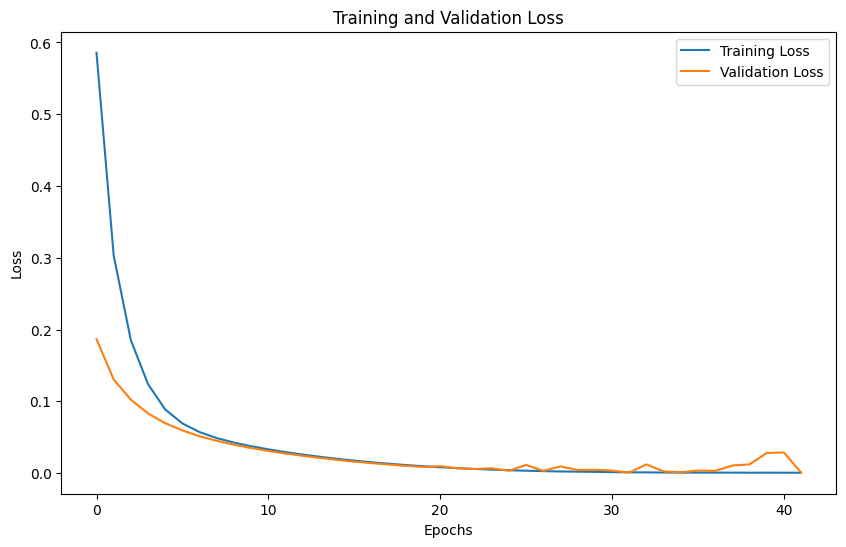

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

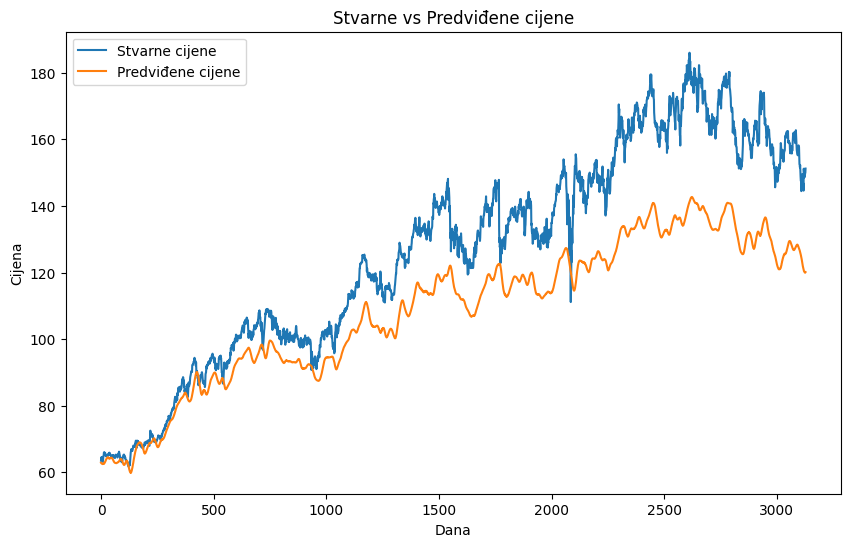

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(real_prices, label='Stvarne cijene')
plt.plot(predicted_prices, label='Predviđene cijene')
plt.title('Stvarne vs Predviđene cijene')
plt.xlabel('Dana')
plt.ylabel('Cijena')
plt.legend()
plt.show()